<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Class-Pre_trained_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm==0.4.5 -q

     |████████████████████████████████| 296kB 22.6MB/s 


In [20]:
!rm train val -r

rm: cannot remove 'train': No such file or directory
rm: cannot remove 'val': No such file or directory


In [21]:
# !wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
!7z x /content/Train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 13524763 bytes (13 MiB)

Extracting archive: /content/Train.7z
--
Path = /content/Train.7z
Type = 7z
Physical Size = 13524763
Headers Size = 13084
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     22% 17 - train/Ancyclostoma sp./Aduodenale_head_A_0_12.jpg                                                            52% 377 - train/Dibothriocephalus latus/Diph_egg_2_0_99.jpg                                                             76% 7

In [22]:
# !wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
!7z x /content/Val.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4593856 bytes (4487 KiB)

Extracting archive: /content/Val.7z
--
Path = /content/Val.7z
Type = 7z
Physical Size = 4593856
Headers Size = 5093
Method = LZMA2:6m
Solid = +
Blocks = 1

  0%     67% 17       Everything is Ok

Folders: 17
Files: 486
Size:       5092491
Compressed: 4593856


In [3]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms

## Cleaning and getting a final data

In [ ]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.csv' not in x]

In [ ]:
data = pd.read_excel("/content/Dataset/all_meta_data.xlsx")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [ ]:
data = pd.read_csv('/content/parasites.csv')

In [ ]:
data['species'].value_counts()

Plasmodium malariae          185
Cyclospora cayetanensis      185
Entamoeba histolytica        180
Ascaris lumbricoides         180
Plasmodium vivax             180
Plasmodium falciparum        180
Giardia duodenalis           180
Plasmodium ovale             170
Strongyloides stercoralis    110
Dibothriocephalus latus      105
Trichuris Trichuria           95
Enterobius vermicularis       90
Toxocara canis                85
Ancyclostoma sp               85
Sarcocystis sp                80
Cryptosporidium sp            80
Plasmodium knowlesi           75
Hymenolepis nana              70
Toxoplasma gondii             65
Trichinella sp                65
Name: species, dtype: int64

In [ ]:
# data = [x for _,x in data.groupby('species') if len(x)>15]

# data = pd.concat(data,ignore_index=True)

label_encoders = dict()
labels = ["phylum","class","species","form","sample"]
for x in labels:
  le = LabelEncoder()
  data[f'{x}_label'] = le.fit_transform(data[x])
  label_encoders[x] = le

In [ ]:
train, val = train_test_split(
    data, test_size=0.25, random_state=2021,stratify = data['species'])

In [ ]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Labeling

In [49]:
train = pd.read_csv("/content/train/train.csv")

val = pd.read_csv("/content/val/val.csv")

In [50]:
le = LabelEncoder()
train['class_label'] = le.fit_transform(train['class'])

val['class_label'] = le.transform(val['class'])

# Dataset Function

In [ ]:
train = train[train['species']!='na']
val = val[val['species']!='na']

In [ ]:
from PIL import Image
from glob import glob
images = [x for x in glob('./val/*/*') if 'val.csv' not in x]
for i in images:
  Image.open(i).convert('RGB').save(i)

In [ ]:
train['img_path'] = train['img_path'].str.replace('/train','./train')
val['img_path'] = val['img_path'].str.replace('/content','./val')

In [51]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = csv_file[['class_label','img_path']]
    self.labels = csv['class_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return img, torch.LongTensor([label])

In [5]:

train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [54]:
7*165,7*480

(1155, 3360)

In [53]:
val['class'].value_counts()

Aconoidasida     165
Chromadorea       95
Conoidasida       80
Cestoda           50
Tubulinea         35
Zooflagellate     35
Enoplea           25
Name: class, dtype: int64

In [55]:
class_counts = train['class_label'].value_counts().to_dict()
weights = torch.tensor([1/class_counts[label] for label in train['class_label'].values])

train_dataset = SpeciesDataset(train,transform=train_transformer)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,
                                           sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=3360))

class_counts = val['class_label'].value_counts().to_dict()
weights = torch.tensor([1/class_counts[label] for label in val['class_label'].values])

val_dataset = SpeciesDataset(val,transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51,
                                         sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=1155))

# VIT Base Imagenet 21k

In [ ]:
vi = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 512)
vi

In [56]:
class ViT(nn.Module):
  def __init__(self,num_classes_classifier=20):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 0)
    self.fc1 = nn.Linear(768,512)
    # self.drop = nn.Dropout(0.4)
    self.norm = nn.BatchNorm1d(512)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = torch.relu(self.fc1(repr))
    # repr = self.drop(repr)
    repr = self.norm(repr)
    output = self.classifier(repr)

    return output  

In [57]:
model = ViT(num_classes_classifier=7)

Removing representation layer for fine-tuning.


In [ ]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [58]:
device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
patience = 10
best_acc = -np.inf

model.to(device)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_acc > best_acc:
    
    print(f'\r\t{best_acc:.3f} --> {val_epoch_acc:.3f}  Updating')
    best_acc = val_epoch_acc
    torch.save(model.state_dict(),'vit-base.bin')
    patience = 10
    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if val_epoch_acc < best_acc:
    patience -=1
    print(f'\r\t Patience -> {patience}')
  if patience<=0:
    print(f'\r\tPatience complete! Best Acc is {best_acc:.3f}')
    break
  

Epoch: 01, Train Loss: 0.371, Train Acc: 89.80%, Val. Loss: 0.581, Val. Acc: 83.02% 
	-inf --> 83.019  Updating
Epoch: 02, Train Loss: 0.018, Train Acc: 99.73%, Val. Loss: 0.764, Val. Acc: 79.81% 
	 Patience -> 9
Epoch: 03, Train Loss: 0.004, Train Acc: 100.00%, Val. Loss: 0.723, Val. Acc: 78.32% 
	 Patience -> 8
Epoch: 04, Train Loss: 0.003, Train Acc: 100.00%, Val. Loss: 0.691, Val. Acc: 79.22% 
	 Patience -> 7
Epoch: 05, Train Loss: 0.002, Train Acc: 100.00%, Val. Loss: 0.801, Val. Acc: 79.12% 
	 Patience -> 6
Epoch: 06, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.706, Val. Acc: 81.04% 
	 Patience -> 5
Epoch: 07, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.797, Val. Acc: 78.62% 
	 Patience -> 4
Epoch: 08, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.843, Val. Acc: 79.12% 
	 Patience -> 3
Epoch: 09, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.854, Val. Acc: 77.35% 
	 Patience -> 2
Epoch: 10, Train Loss: 0.001, Train Acc: 100.00%, Val. Loss: 0.930, Val. 

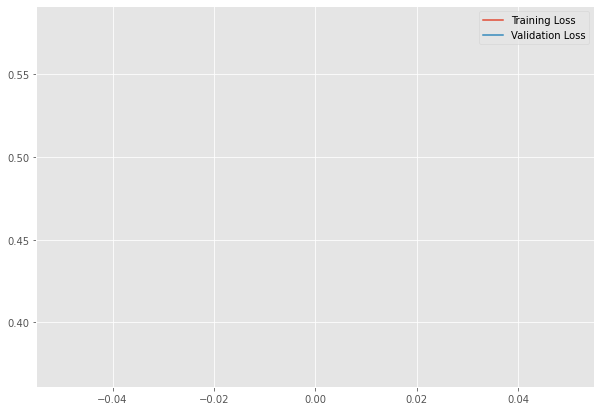

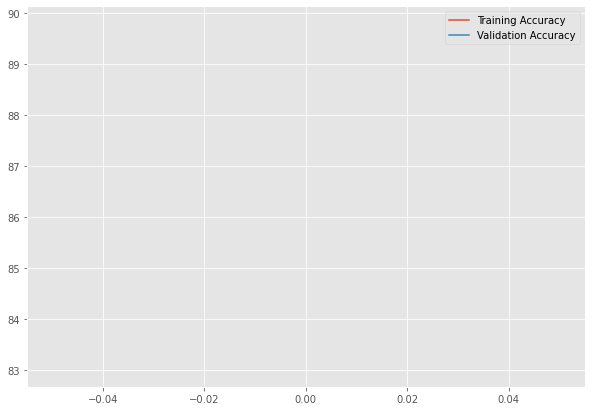

In [62]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val,transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=615)

model.load_state_dict(torch.load('vit-base.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=le.classes_))

               precision    recall  f1-score   support

 Aconoidasida       0.96      0.99      0.98       165
      Cestoda       0.76      0.52      0.62        50
  Chromadorea       0.81      0.84      0.82        95
  Conoidasida       0.91      0.96      0.93        80
      Enoplea       0.71      0.68      0.69        25
    Tubulinea       0.86      0.91      0.89        35
Zooflagellate       0.89      0.94      0.92        35

     accuracy                           0.88       485
    macro avg       0.84      0.84      0.84       485
 weighted avg       0.88      0.88      0.88       485



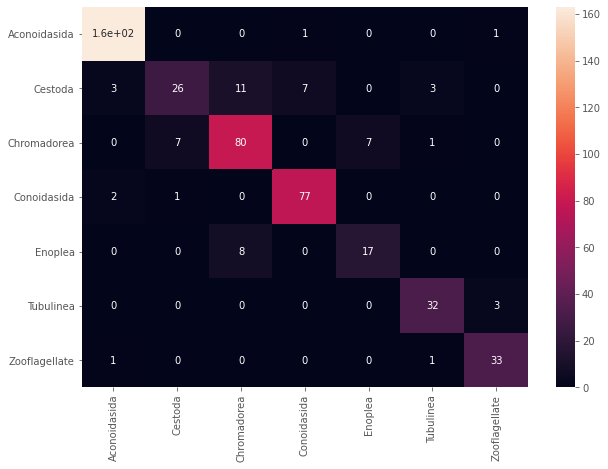

In [61]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()